### well structured - an ode to databases


# data preparation

### import libraries

In [795]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

## build stock preparation class

In [796]:
class stock_prep:
    def __init__(self, company_name):

        # load data
        self.company_stock_prices = pd.read_csv('data/' + company_name)[['Date', 'Close']] #input genauere Beschreibung
        self.company_name = company_name

        # return dfs
        self.replace_company_stock_prices = []
        self.missing_company_stock_prices = []
        self.avg_norm_loss_company_stock_prices = []
        self.formatted_date_to_index = []
        self.standardization_company_stock_prices = []
        self.normalization_company_stock_prices = []
        self.binning_company_stock_prices = []
        self.indicator_variables_stock_prices = []
        self.to_sql_stock_prices = []

    def pipeline_conductor(self,pipeline):
        pass

    def replace_values(self):
        self.replace_company_stock_prices = self.company_stock_prices.replace("?", np.nan)
        
    def missing_values_count(self):

        # count missing values
        self.missing_company_stock_prices = self.replace_company_stock_prices.isnull()
        self.missing_company_stock_prices = self.missing_company_stock_prices['Close'].value_counts()
    
    def avg_norm_loss(self):

        # calculate mean and replace missing values
        aux_var_avg_norm_loss = self.replace_company_stock_prices["Close"].astype("float").mean(axis=0)
        self.replace_company_stock_prices['Close'] = self.replace_company_stock_prices['Close'].replace(np.nan, aux_var_avg_norm_loss)

        # rename Series for df
        first_item = self.replace_company_stock_prices['Date'].rename('date_date')
        second_item = self.replace_company_stock_prices['Close'].rename('close_avg_norm_loss')

        # build df
        self.avg_norm_loss_company_stock_prices = pd.concat([first_item, second_item], axis=1)

    def format_date_to_index(self):

        # format date to int
        aux_var_replaced_date = self.avg_norm_loss_company_stock_prices['date_date'].str.replace('-', '', regex=True).astype(np.int64)
        self.avg_norm_loss_company_stock_prices['close_avg_norm_loss'] = self.avg_norm_loss_company_stock_prices['close_avg_norm_loss'].astype(np.float64)

        # rename Series for df
        first_item = self.avg_norm_loss_company_stock_prices
        second_item = aux_var_replaced_date.rename('date_int')

        # build df
        self.formatted_date_to_index = pd.concat([first_item, second_item], axis=1)
        
    def standardization(self):

        # standardize close_avg_norm_loss
        aux_var_form_ind = self.formatted_date_to_index['date_int']/self.formatted_date_to_index["close_avg_norm_loss"]

        # rename Series for df
        first_item = self.formatted_date_to_index
        second_item =  aux_var_form_ind.rename("close_stand")

        # build df        
        self.standardization_company_stock_prices = pd.concat([first_item, second_item], axis=1)
        
    def normalization(self):

        # replace (original value) by (original value)/(maximum value)
        aux_var_norm_close = self.standardization_company_stock_prices['close_stand']/self.standardization_company_stock_prices['close_stand'].max()

        # rename Series for df
        first_item = self.standardization_company_stock_prices
        second_item = aux_var_norm_close.rename("close_normal")

        # build df
        self.normalization_company_stock_prices = pd.concat([first_item, second_item], axis=1)
        
    def binning(self):

        # build bins
        aux_var_bins = np.linspace(min(self.normalization_company_stock_prices["close_normal"]), max(self.normalization_company_stock_prices["close_normal"]), 4)
        aux_var_group_names = ["Low", "Medium", "High"]
        aux_var_build_bins = pd.cut(self.normalization_company_stock_prices['close_normal'], aux_var_bins, labels = aux_var_group_names, include_lowest= True)

        # rename Series for df
        first_item = self.normalization_company_stock_prices
        second_item = aux_var_build_bins.rename("close_binned")

        # build df
        self.binning_company_stock_prices = pd.concat([first_item, second_item], axis=1)

    def plot_bins(self):

        plt.hist(self.binning_company_stock_prices["close_binned"], bins = 3)
       
        plt.xlabel("amount")
        plt.ylabel("close_binned")
        plt.title("Close_Price_Categories")

    def indicator_variables(self):

        # build indicators
        aux_var_indi = pd.get_dummies(self.binning_company_stock_prices["close_binned"])
        aux_var_drop = self.binning_company_stock_prices.drop(['close_binned'], axis = 1)

        # rename Series for df
        first_item = aux_var_drop
        second_item = aux_var_indi #.rename(columns={'Medium':'close_price_medium', 'High':'close_price_high'}, inplace=True)

        # # build df
        self.indicator_variables_stock_prices = pd.concat([first_item, second_item], axis=1)

    def to_sqlite_database(self):
        conn = sqlite3.connect('stocks_prep.db')
        self.indicator_variables_stock_prices.to_sql(name=self.company_name, con=conn, if_exists='replace')
        conn.commit()
        conn.close() 

In [797]:
stock_prep_obj = stock_prep('iShares Global Timber & Forestry UCITS ETF USD Acc.csv')

## identify and handling missing values

In [798]:
#replace missing values
stock_prep_obj.replace_values()
print(stock_prep_obj.replace_company_stock_prices.head(5))

         Date               Close
0  2021-11-05                 NaN
1  2021-11-08   30.70560073852539
2  2021-11-09  30.667200088500977
3  2021-11-10   30.44179916381836
4  2021-11-11  30.740800857543945


In [799]:
#identify missing values
stock_prep_obj.missing_values_count()
print(stock_prep_obj.missing_company_stock_prices)

Close
False    608
True       1
Name: count, dtype: int64


In [800]:
#handling missing values
stock_prep_obj.avg_norm_loss()
print(stock_prep_obj.avg_norm_loss_company_stock_prices.head(5))

    date_date close_avg_norm_loss
0  2021-11-05           26.664175
1  2021-11-08   30.70560073852539
2  2021-11-09  30.667200088500977
3  2021-11-10   30.44179916381836
4  2021-11-11  30.740800857543945


## correct dataformat

In [801]:
stock_prep_obj.format_date_to_index()
print(stock_prep_obj.formatted_date_to_index.head(5))

    date_date  close_avg_norm_loss  date_int
0  2021-11-05            26.664175  20211105
1  2021-11-08            30.705601  20211108
2  2021-11-09            30.667200  20211109
3  2021-11-10            30.441799  20211110
4  2021-11-11            30.740801  20211111


## data standardization

In [802]:
stock_prep_obj.standardization()
print(stock_prep_obj.standardization_company_stock_prices.head(5))


    date_date  close_avg_norm_loss  date_int    close_stand
0  2021-11-05            26.664175  20211105  757987.247871
1  2021-11-08            30.705601  20211108  658222.197706
2  2021-11-09            30.667200  20211109  659046.438595
3  2021-11-10            30.441799  20211110  663926.264385
4  2021-11-11            30.740801  20211111  657468.590154


# normalization

In [803]:
stock_prep_obj.normalization()
print(stock_prep_obj.normalization_company_stock_prices.head(5))

    date_date  close_avg_norm_loss  date_int    close_stand  close_normal
0  2021-11-05            26.664175  20211105  757987.247871      0.851640
1  2021-11-08            30.705601  20211108  658222.197706      0.739549
2  2021-11-09            30.667200  20211109  659046.438595      0.740475
3  2021-11-10            30.441799  20211110  663926.264385      0.745958
4  2021-11-11            30.740801  20211111  657468.590154      0.738702


## binning

    date_date  close_avg_norm_loss  date_int    close_stand  close_normal  \
0  2021-11-05            26.664175  20211105  757987.247871      0.851640   
1  2021-11-08            30.705601  20211108  658222.197706      0.739549   
2  2021-11-09            30.667200  20211109  659046.438595      0.740475   
3  2021-11-10            30.441799  20211110  663926.264385      0.745958   
4  2021-11-11            30.740801  20211111  657468.590154      0.738702   

  close_binned  
0       Medium  
1          Low  
2          Low  
3          Low  
4          Low  


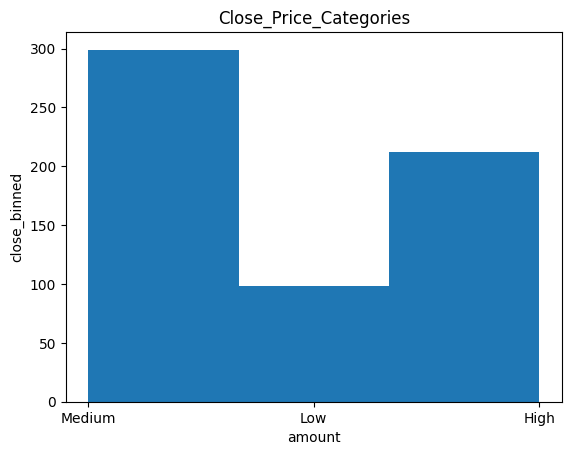

In [804]:
stock_prep_obj.binning()
print(stock_prep_obj.binning_company_stock_prices.head(5))
stock_prep_obj.plot_bins()

## indicator Variables

In [805]:
stock_prep_obj.indicator_variables()
print(stock_prep_obj.indicator_variables_stock_prices.head(5))

    date_date  close_avg_norm_loss  date_int    close_stand  close_normal  \
0  2021-11-05            26.664175  20211105  757987.247871      0.851640   
1  2021-11-08            30.705601  20211108  658222.197706      0.739549   
2  2021-11-09            30.667200  20211109  659046.438595      0.740475   
3  2021-11-10            30.441799  20211110  663926.264385      0.745958   
4  2021-11-11            30.740801  20211111  657468.590154      0.738702   

     Low  Medium   High  
0  False    True  False  
1   True   False  False  
2   True   False  False  
3   True   False  False  
4   True   False  False  


## store in  stock_prep db

In [806]:
stock_prep_obj.to_sqlite_database()

# store data in sqlite db

In [807]:
#ticker_symbols = ['WOOE.AS', 'WY', 'SCA-B.ST', 'SUZ', 'SK3.IR', 'IP', 'STERV.HE','RYN', 'WFG', 'WRK', 'PCH']
file_names = os.listdir('data/')
#print(file_names)

for file_name in file_names:

    # call init class
    stock_prep_obj = stock_prep(file_name)

    # replace missing values
    stock_prep_obj.replace_values()
    
    # identify missing values
    stock_prep_obj.missing_values_count()
    
    # handling missing values
    stock_prep_obj.avg_norm_loss()

    # data_format
    stock_prep_obj.format_date_to_index()

    # data standardization
    stock_prep_obj.standardization()

    # data normalization
    stock_prep_obj.normalization()

    # binning
    stock_prep_obj.binning()
    # stock_prep_obj.plot_bins()

    # indicator variables
    stock_prep_obj.indicator_variables()

    # data in sqlite database
    stock_prep_obj.to_sqlite_database()

    print('stored in stocks_prep db: ' + file_name)

    

stored in stocks_prep db: iShares Global Timber & Forestry UCITS ETF USD Acc.csv


stored in stocks_prep db: Weyerhaeuser Company.csv
stored in stocks_prep db: Svenska Cellulosa Aktiebolaget SCA (publ).csv
stored in stocks_prep db: Suzano S.A..csv
stored in stocks_prep db: Smurfit Kappa Group Plc.csv
stored in stocks_prep db: International Paper Company.csv
stored in stocks_prep db: Stora Enso Oyj.csv
stored in stocks_prep db: Rayonier Inc..csv
stored in stocks_prep db: West Fraser Timber Co. Ltd..csv
stored in stocks_prep db: WestRock Company.csv
stored in stocks_prep db: PotlatchDeltic Corporation.csv
